# **CDS Project: Part 2**

*Institute of Software Security (E22)*  
*Hamburg University of Technology*  
*SoSe 2023*

## Learning objectives
---

- Identify and extract vulnerable code from software reposiroties
- Identify and extract non-vulnerabile code from software reposiroties.
- Select and apply pre-proceesing techniques.
- Create a dataset of security vulnerabilities.

## Materials
---

- Lecture Slides 3, 5 and 6.
- PyTorch Documentation: [Datasets and Data Loaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) 
- [ProjectKB GitHub repo](https://github.com/SAP/project-kb).
- PyDriller Documentation: [PyDriller](https://pydriller.readthedocs.io/en/latest/)

## Project Description
---

In this project, you will create your own dataset of security vulnerabilities. This dataset should be generated using the information contained in ProjectKB. ProjectKB is a repository created to enable the creation, management and aggregation of a distributed and collaborative knowledge base of vulnerabilities affecting open-source software written in Java programming language. This repository contains a list of CVEs and the corresponding commits that fix it. Usually the vulnerabilities are contained in a method. Your task is to use this repository to extract the vulnerable and fixed version of the methods.

### *Task 1*

- Download the ProjectKB repository (i.e., create a local copy by cloning it).
- Locate the folder containing the CVEs and their corresponding fixing commits.

#### Task 1 Sol:
The data is saved in csv: data_students/vulas_db_msr2019_release.csv

Data structure:
```(vulnerability id, repository url, commit id, class)```

### *Task 2*

- Write a script that extracts (i) the repository URLs and (ii) corresponding fixing commit ID (hash) contained on each CVE.

In [1]:
from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper
from pathlib import Path

root_directory = Path('data_students/project-kb-vulnerability-data/statements/')

# Get all files in any folder inside root_directory
yaml_files = root_directory.glob('**/*.yaml')

# TODO: From ProjectKB extract the commit IDs of the fixing commits  
# TODO: Extract the URLs of the repositories that contain the fix for different CVEs
url_commit_dict = {}

for file_path in yaml_files:
    # Perform operations on each YAML file
    with open(file_path, 'r', encoding='utf-8') as file:
        # Read the YAML content
        yaml_content = load(file, Loader=Loader)
        try:
            fixes = yaml_content['fixes']
            for fixesId in fixes:
                for commitID in fixesId['commits']:
                    url_commit_dict[commitID['id']] = commitID['repository']
        except KeyError:
            continue

In [2]:
print(url_commit_dict)
print(len(url_commit_dict))

{'c9cd1e521673ef0cccb8795b78d3cbaefb8a576a': 'https://github.com/igniterealtime/Openfire', '04fcefa44bae1263c7cad6986a9dafed67f0164': 'https://github.com/apache/struts', 'ff8b655c4b04cae41e5ad00df0a7482333e7a25': 'https://github.com/apache/struts', '09147ffad2b3046ed21af0f524c5088e2ac551e': 'https://github.com/apache/struts', 'bd3f2f59c9b09f70aed3ebab6bb69b464ee2d6c': 'https://github.com/apache/struts', 'dae026a0f0511f83852053bae9d5a622e7f8048': 'https://github.com/apache/struts', 'dbc620f84ffb626c6e6738afe0578d617a2b3d3': 'https://github.com/apache/struts', '93866341ec5396d07b5829be55110ff09dc81bc': 'https://github.com/apache/struts', '787352': 'http://svn.apache.org/repos/asf/xerces/java', '2895197d0dad246757d8d1d9eea181cbf0543ae9': 'https://git-wip-us.apache.org/repos/asf/activemq.git', '9dc43f3ffe85c9c56faee235a21f23bfceb865c8': 'https://git-wip-us.apache.org/repos/asf/activemq.git', 'fed39c3619825bd92990cf1aa7a4e85119e00a6e': 'https://git-wip-us.apache.org/repos/asf/activemq.git',

### *Task 3*

- Using the URL, identify and extract the method where the "fix" is introduced. 
- Locate the previous version of the file and extract the same function (i.e., the "vulnerable" version of the same function). 

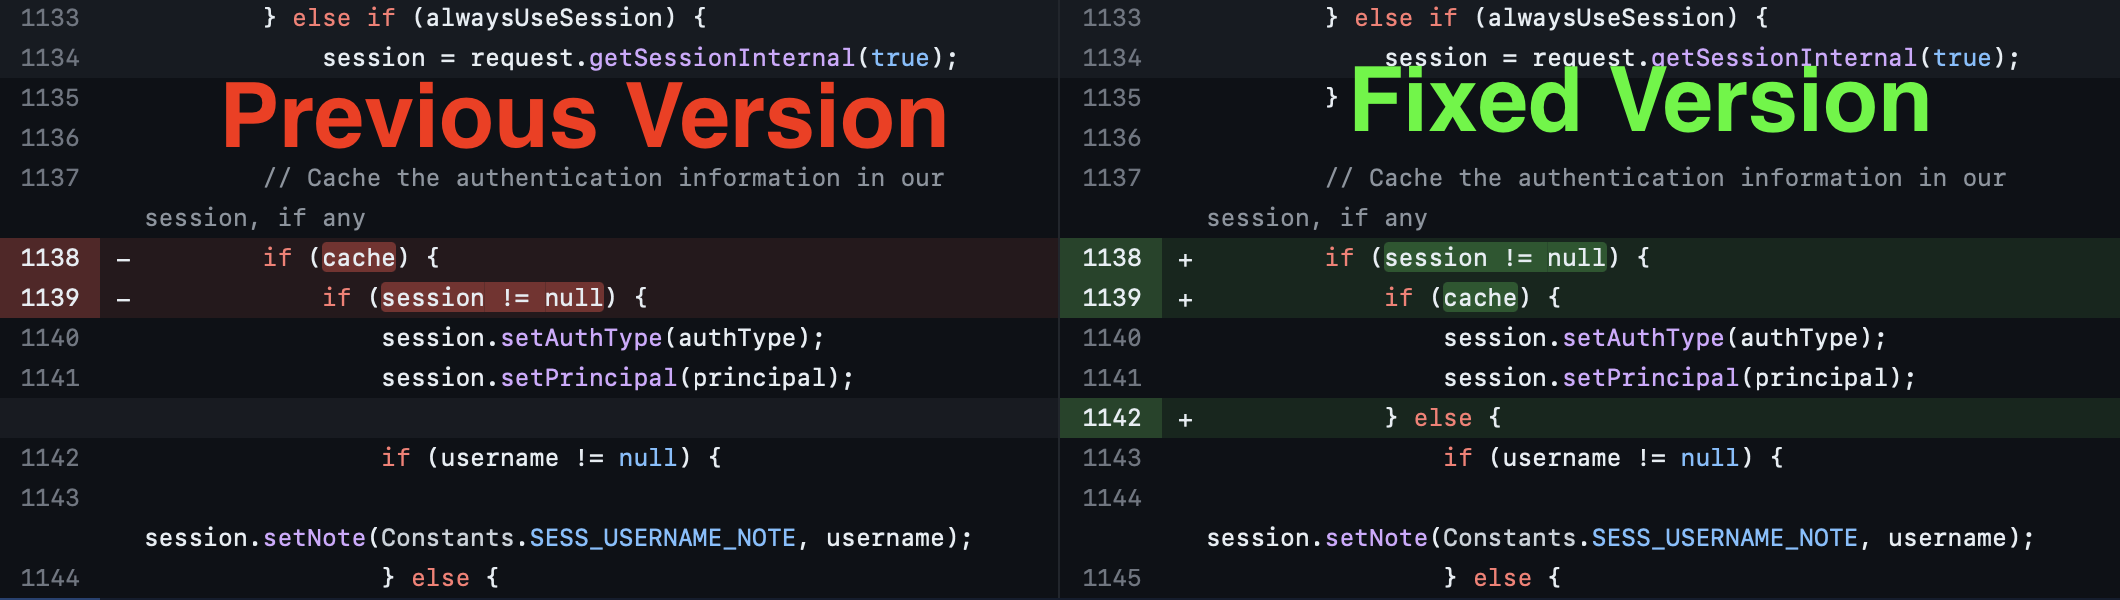

In [3]:
import os

# Specify the full path to the git executable
os.environ['GIT_PYTHON_GIT_EXECUTABLE'] = 'C:\\Program Files\\Git\\bin\\git.exe'

from pydriller import Repository
testCommit = list(url_commit_dict.keys())[2]
print(testCommit)
print(url_commit_dict[testCommit])

# TODO: Extract the method where the fix is introduced

# TODO: Extract the vulnerable version of the same method from the previous version of the file.

ff8b655c4b04cae41e5ad00df0a7482333e7a25
https://github.com/apache/struts


In [4]:
import os

# Specify the full path to the git executable
os.environ['GIT_PYTHON_GIT_EXECUTABLE'] = 'C:\\Program Files\\Git\\bin\\git.exe'

import csv
from pydriller import Repository

def extract_code_changes(url_commit_dict, output_csv):
    total_commits = len(url_commit_dict)
    processed_commits = 0

    with open(output_csv, "w", encoding="UTF8", newline="") as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(["method_name", "old_code", "new_code", "is_vulnerable"])
        
        for commit_id, repo_url in url_commit_dict.items():
            try:
                for commit in Repository(repo_url, single=commit_id, num_workers=10).traverse_commits():
                    for modified_file in commit.modified_files:
                        for changed_method in modified_file.changed_methods:
                            if 'test' in changed_method.name.lower():
                                continue

                            old_method = next((method for method in modified_file.methods_before if method.name == changed_method.name), None)
                            new_method = next((method for method in modified_file.methods if method.name == changed_method.name), None)

                            if old_method is None or new_method is None:
                                continue

                            old_code = '\n'.join(modified_file.source_code_before[old_method.start_line - 1:old_method.end_line])
                            new_code = '\n'.join(modified_file.source_code[new_method.start_line - 1:new_method.end_line])

                            if old_code == new_code:
                                continue

                            writer.writerow([changed_method.name, old_code, new_code, 1 if old_code != new_code else 0])
            except Exception as e:
                print(f"Error processing commit {commit_id}: {e}")
            finally:
                processed_commits += 1
                print(f"{processed_commits}/{total_commits} commits processed")

if __name__ == "__main__":
    output_csv = "./code_csv.csv"
    extract_code_changes(url_commit_dict, output_csv)


1/1782 commits processed
2/1782 commits processed
3/1782 commits processed
4/1782 commits processed
5/1782 commits processed
6/1782 commits processed
7/1782 commits processed
8/1782 commits processed
Error processing commit 787352: Cmd('C:\Program Files\Git\bin\git.exe') failed due to: exit code(128)
  cmdline: C:\Program Files\Git\bin\git.exe clone -v -- http://svn.apache.org/repos/asf/xerces/java C:\Users\GEETHIKA\AppData\Local\Temp\tmp8hg3d7lz\java
  stderr: 'Cloning into 'C:\Users\GEETHIKA\AppData\Local\Temp\tmp8hg3d7lz\java'...
fatal: repository 'http://svn.apache.org/repos/asf/xerces/java/' not found
'
9/1782 commits processed
10/1782 commits processed
11/1782 commits processed
12/1782 commits processed
13/1782 commits processed
14/1782 commits processed
15/1782 commits processed
Error processing commit 1076586: Cmd('C:\Program Files\Git\bin\git.exe') failed due to: exit code(128)
  cmdline: C:\Program Files\Git\bin\git.exe clone -v -- http://svn.apache.org/repos/asf/tomcat C:\Us

Exception ignored in: <finalize object at 0x250448d7ce0; dead>
Traceback (most recent call last):
  File "c:\Python312\Lib\weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\tempfile.py", line 935, in _cleanup
    cls._rmtree(name, ignore_errors=ignore_errors)
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(name, onexc=onexc)
  File "c:\Python312\Lib\shutil.py", line 820, in rmtree
    return _rmtree_unsafe(path, onexc)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\shutil.py", line 643, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onexc)
  File "c:\Python312\Lib\shutil.py", line 652, in _rmtree_unsafe
    onexc(os.rmdir, path, err)
  File "c:\Python312\Lib\tempfile.py", line 920, in onexc
    cls._rmtree(path, ignore_errors=ignore_errors,
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(

31/1782 commits processed
Error processing commit f4e8981e4b17cc1ee9d3c79f6cd34f7bb2201f7: The commit f4e8981e4b17cc1ee9d3c79f6cd34f7bb2201f7 defined in the 'single' filtered does not exist


Exception ignored in: <finalize object at 0x250448d5b80; dead>
Traceback (most recent call last):
  File "c:\Python312\Lib\weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\tempfile.py", line 935, in _cleanup
    cls._rmtree(name, ignore_errors=ignore_errors)
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(name, onexc=onexc)
  File "c:\Python312\Lib\shutil.py", line 820, in rmtree
    return _rmtree_unsafe(path, onexc)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\shutil.py", line 643, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onexc)
  File "c:\Python312\Lib\shutil.py", line 652, in _rmtree_unsafe
    onexc(os.rmdir, path, err)
  File "c:\Python312\Lib\tempfile.py", line 920, in onexc
    cls._rmtree(path, ignore_errors=ignore_errors,
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(

32/1782 commits processed
33/1782 commits processed
Error processing commit 1209700: Cmd('C:\Program Files\Git\bin\git.exe') failed due to: exit code(128)
  cmdline: C:\Program Files\Git\bin\git.exe clone -v -- http://svn.apache.org/repos/asf/activemq C:\Users\GEETHIKA\AppData\Local\Temp\tmplure3_94\activemq
  stderr: 'Cloning into 'C:\Users\GEETHIKA\AppData\Local\Temp\tmplure3_94\activemq'...
fatal: repository 'http://svn.apache.org/repos/asf/activemq/' not found
'
34/1782 commits processed
35/1782 commits processed
36/1782 commits processed
37/1782 commits processed
38/1782 commits processed
39/1782 commits processed
40/1782 commits processed
41/1782 commits processed
42/1782 commits processed
43/1782 commits processed
44/1782 commits processed
45/1782 commits processed
46/1782 commits processed
47/1782 commits processed
Error processing commit 1409324: Cmd('C:\Program Files\Git\bin\git.exe') failed due to: exit code(128)
  cmdline: C:\Program Files\Git\bin\git.exe clone -v -- http:/

Exception ignored in: <finalize object at 0x250448d7f20; dead>
Traceback (most recent call last):
  File "c:\Python312\Lib\weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\tempfile.py", line 935, in _cleanup
    cls._rmtree(name, ignore_errors=ignore_errors)
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(name, onexc=onexc)
  File "c:\Python312\Lib\shutil.py", line 820, in rmtree
    return _rmtree_unsafe(path, onexc)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\shutil.py", line 643, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onexc)
  File "c:\Python312\Lib\shutil.py", line 652, in _rmtree_unsafe
    onexc(os.rmdir, path, err)
  File "c:\Python312\Lib\tempfile.py", line 920, in onexc
    cls._rmtree(path, ignore_errors=ignore_errors,
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(

Error processing commit 3d476326c7ff32fe17357ac44a7fe194874df246: SHA b'3d476326c7ff32fe17357ac44a7fe194874df246' could not be resolved, git returned: b'3d476326c7ff32fe17357ac44a7fe194874df246 missing'
107/1782 commits processed


Exception ignored in: <finalize object at 0x250448d77c0; dead>
Traceback (most recent call last):
  File "c:\Python312\Lib\weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\tempfile.py", line 935, in _cleanup
    cls._rmtree(name, ignore_errors=ignore_errors)
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(name, onexc=onexc)
  File "c:\Python312\Lib\shutil.py", line 820, in rmtree
    return _rmtree_unsafe(path, onexc)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\shutil.py", line 643, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onexc)
  File "c:\Python312\Lib\shutil.py", line 652, in _rmtree_unsafe
    onexc(os.rmdir, path, err)
  File "c:\Python312\Lib\tempfile.py", line 920, in onexc
    cls._rmtree(path, ignore_errors=ignore_errors,
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(

Error processing commit 9827e56928abd657a7e7887f7e82ac9bc8a9c10b: SHA b'9827e56928abd657a7e7887f7e82ac9bc8a9c10b' could not be resolved, git returned: b'9827e56928abd657a7e7887f7e82ac9bc8a9c10b missing'
108/1782 commits processed
109/1782 commits processed
110/1782 commits processed
111/1782 commits processed
112/1782 commits processed
113/1782 commits processed
114/1782 commits processed
115/1782 commits processed
116/1782 commits processed
117/1782 commits processed
118/1782 commits processed
119/1782 commits processed
120/1782 commits processed
121/1782 commits processed
122/1782 commits processed
123/1782 commits processed
124/1782 commits processed
125/1782 commits processed
126/1782 commits processed
127/1782 commits processed
Error processing commit 54b65c1d30848835f26bd138c0ba407bc1e560d: Cmd('C:\Program Files\Git\bin\git.exe') failed due to: exit code(128)
  cmdline: C:\Program Files\Git\bin\git.exe clone -v -- https://git-wip-us.apache.org/repos/asf/camel.git C:\Users\GEETHIK

Exception ignored in: <finalize object at 0x2504464bde0; dead>
Traceback (most recent call last):
  File "c:\Python312\Lib\weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\tempfile.py", line 935, in _cleanup
    cls._rmtree(name, ignore_errors=ignore_errors)
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(name, onexc=onexc)
  File "c:\Python312\Lib\shutil.py", line 820, in rmtree
    return _rmtree_unsafe(path, onexc)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\shutil.py", line 643, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onexc)
  File "c:\Python312\Lib\shutil.py", line 652, in _rmtree_unsafe
    onexc(os.rmdir, path, err)
  File "c:\Python312\Lib\tempfile.py", line 920, in onexc
    cls._rmtree(path, ignore_errors=ignore_errors,
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(

391/1782 commits processed
392/1782 commits processed
393/1782 commits processed
394/1782 commits processed
395/1782 commits processed
396/1782 commits processed
397/1782 commits processed
398/1782 commits processed
399/1782 commits processed
400/1782 commits processed
401/1782 commits processed
402/1782 commits processed
403/1782 commits processed


Exception ignored in: <finalize object at 0x2504464bcc0; dead>
Traceback (most recent call last):
  File "c:\Python312\Lib\weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\tempfile.py", line 935, in _cleanup
    cls._rmtree(name, ignore_errors=ignore_errors)
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(name, onexc=onexc)
  File "c:\Python312\Lib\shutil.py", line 820, in rmtree
    return _rmtree_unsafe(path, onexc)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\shutil.py", line 643, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onexc)
  File "c:\Python312\Lib\shutil.py", line 652, in _rmtree_unsafe
    onexc(os.rmdir, path, err)
  File "c:\Python312\Lib\tempfile.py", line 920, in onexc
    cls._rmtree(path, ignore_errors=ignore_errors,
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(

Error processing commit 1ccc66bb693d4e46a34a904db8eeff07808d2ced: SHA b'1ccc66bb693d4e46a34a904db8eeff07808d2ced' could not be resolved, git returned: b'1ccc66bb693d4e46a34a904db8eeff07808d2ced missing'
404/1782 commits processed


Exception ignored in: <finalize object at 0x250448d7f00; dead>
Traceback (most recent call last):
  File "c:\Python312\Lib\weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\tempfile.py", line 935, in _cleanup
    cls._rmtree(name, ignore_errors=ignore_errors)
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(name, onexc=onexc)
  File "c:\Python312\Lib\shutil.py", line 820, in rmtree
    return _rmtree_unsafe(path, onexc)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\shutil.py", line 643, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onexc)
  File "c:\Python312\Lib\shutil.py", line 652, in _rmtree_unsafe
    onexc(os.rmdir, path, err)
  File "c:\Python312\Lib\tempfile.py", line 920, in onexc
    cls._rmtree(path, ignore_errors=ignore_errors,
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(

Error processing commit 7c68fde2d6fc65e362f20863d868c112a90a9b49: SHA b'7c68fde2d6fc65e362f20863d868c112a90a9b49' could not be resolved, git returned: b'7c68fde2d6fc65e362f20863d868c112a90a9b49 missing'
405/1782 commits processed
406/1782 commits processed
407/1782 commits processed
408/1782 commits processed
409/1782 commits processed
410/1782 commits processed
411/1782 commits processed
412/1782 commits processed
Error processing commit 6bd694b7980494c12d49ca1bf39f12aec3e03e2f:2_5_x: "Blob or Tree named '2_5_x^0' not found"


Exception ignored in: <finalize object at 0x250448d70c0; dead>
Traceback (most recent call last):
  File "c:\Python312\Lib\weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\tempfile.py", line 935, in _cleanup
    cls._rmtree(name, ignore_errors=ignore_errors)
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(name, onexc=onexc)
  File "c:\Python312\Lib\shutil.py", line 820, in rmtree
    return _rmtree_unsafe(path, onexc)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\shutil.py", line 643, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onexc)
  File "c:\Python312\Lib\shutil.py", line 652, in _rmtree_unsafe
    onexc(os.rmdir, path, err)
  File "c:\Python312\Lib\tempfile.py", line 920, in onexc
    cls._rmtree(path, ignore_errors=ignore_errors,
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(

413/1782 commits processed
Error processing commit 98d2692e434fe7f4d445ade24fe2c9860de1c13f:2_3_x: "Blob or Tree named '2_3_x^0' not found"


Exception ignored in: <finalize object at 0x250448d7d80; dead>
Traceback (most recent call last):
  File "c:\Python312\Lib\weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\tempfile.py", line 935, in _cleanup
    cls._rmtree(name, ignore_errors=ignore_errors)
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(name, onexc=onexc)
  File "c:\Python312\Lib\shutil.py", line 820, in rmtree
    return _rmtree_unsafe(path, onexc)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\shutil.py", line 643, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onexc)
  File "c:\Python312\Lib\shutil.py", line 652, in _rmtree_unsafe
    onexc(os.rmdir, path, err)
  File "c:\Python312\Lib\tempfile.py", line 920, in onexc
    cls._rmtree(path, ignore_errors=ignore_errors,
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(

414/1782 commits processed
415/1782 commits processed
416/1782 commits processed
417/1782 commits processed
418/1782 commits processed
419/1782 commits processed
420/1782 commits processed
421/1782 commits processed
422/1782 commits processed
423/1782 commits processed
424/1782 commits processed
425/1782 commits processed
426/1782 commits processed
427/1782 commits processed
428/1782 commits processed
429/1782 commits processed
430/1782 commits processed
431/1782 commits processed
432/1782 commits processed
433/1782 commits processed
434/1782 commits processed
435/1782 commits processed
436/1782 commits processed
437/1782 commits processed
438/1782 commits processed
439/1782 commits processed
440/1782 commits processed
441/1782 commits processed
Error processing commit 04b8a19f81ee616c315eec639642439b3a18ad9: Cmd('C:\Program Files\Git\bin\git.exe') failed due to: exit code(128)
  cmdline: C:\Program Files\Git\bin\git.exe clone -v -- https://github.com/apache/hadoop C:\Users\GEETHIKA\Ap

Exception ignored in: <finalize object at 0x2504464b3c0; dead>
Traceback (most recent call last):
  File "c:\Python312\Lib\weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\tempfile.py", line 935, in _cleanup
    cls._rmtree(name, ignore_errors=ignore_errors)
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(name, onexc=onexc)
  File "c:\Python312\Lib\shutil.py", line 820, in rmtree
    return _rmtree_unsafe(path, onexc)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\shutil.py", line 643, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onexc)
  File "c:\Python312\Lib\shutil.py", line 652, in _rmtree_unsafe
    onexc(os.rmdir, path, err)
  File "c:\Python312\Lib\tempfile.py", line 920, in onexc
    cls._rmtree(path, ignore_errors=ignore_errors,
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(

552/1782 commits processed
Error processing commit cd6236c74b55763a27e3e9b5f269c28bc9c98419: SHA b'cd6236c74b55763a27e3e9b5f269c28bc9c98419' could not be resolved, git returned: b'cd6236c74b55763a27e3e9b5f269c28bc9c98419 missing'


Exception ignored in: <finalize object at 0x250448d7b20; dead>
Traceback (most recent call last):
  File "c:\Python312\Lib\weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\tempfile.py", line 935, in _cleanup
    cls._rmtree(name, ignore_errors=ignore_errors)
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(name, onexc=onexc)
  File "c:\Python312\Lib\shutil.py", line 820, in rmtree
    return _rmtree_unsafe(path, onexc)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\shutil.py", line 643, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onexc)
  File "c:\Python312\Lib\shutil.py", line 652, in _rmtree_unsafe
    onexc(os.rmdir, path, err)
  File "c:\Python312\Lib\tempfile.py", line 920, in onexc
    cls._rmtree(path, ignore_errors=ignore_errors,
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(

553/1782 commits processed
Error processing commit df3910135fd9c442b4e746e4b156362fd2e8d755: SHA b'df3910135fd9c442b4e746e4b156362fd2e8d755' could not be resolved, git returned: b'df3910135fd9c442b4e746e4b156362fd2e8d755 missing'


Exception ignored in: <finalize object at 0x250448d7960; dead>
Traceback (most recent call last):
  File "c:\Python312\Lib\weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\tempfile.py", line 935, in _cleanup
    cls._rmtree(name, ignore_errors=ignore_errors)
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(name, onexc=onexc)
  File "c:\Python312\Lib\shutil.py", line 820, in rmtree
    return _rmtree_unsafe(path, onexc)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\shutil.py", line 643, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onexc)
  File "c:\Python312\Lib\shutil.py", line 652, in _rmtree_unsafe
    onexc(os.rmdir, path, err)
  File "c:\Python312\Lib\tempfile.py", line 920, in onexc
    cls._rmtree(path, ignore_errors=ignore_errors,
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(

554/1782 commits processed
Error processing commit a07ed9e86474da98f204efadfd5b9327009a0d21: SHA b'a07ed9e86474da98f204efadfd5b9327009a0d21' could not be resolved, git returned: b'a07ed9e86474da98f204efadfd5b9327009a0d21 missing'


Exception ignored in: <finalize object at 0x250448d7c00; dead>
Traceback (most recent call last):
  File "c:\Python312\Lib\weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\tempfile.py", line 935, in _cleanup
    cls._rmtree(name, ignore_errors=ignore_errors)
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(name, onexc=onexc)
  File "c:\Python312\Lib\shutil.py", line 820, in rmtree
    return _rmtree_unsafe(path, onexc)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\shutil.py", line 643, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onexc)
  File "c:\Python312\Lib\shutil.py", line 652, in _rmtree_unsafe
    onexc(os.rmdir, path, err)
  File "c:\Python312\Lib\tempfile.py", line 920, in onexc
    cls._rmtree(path, ignore_errors=ignore_errors,
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(

555/1782 commits processed
556/1782 commits processed
557/1782 commits processed
558/1782 commits processed
559/1782 commits processed
560/1782 commits processed
561/1782 commits processed
562/1782 commits processed
563/1782 commits processed
564/1782 commits processed
565/1782 commits processed
566/1782 commits processed
567/1782 commits processed
568/1782 commits processed
569/1782 commits processed
570/1782 commits processed
571/1782 commits processed
572/1782 commits processed
573/1782 commits processed
574/1782 commits processed
575/1782 commits processed
Error processing commit 97a8d1d62612683817c785e99c4166bcde8cf1c: Cmd('C:\Program Files\Git\bin\git.exe') failed due to: exit code(128)
  cmdline: C:\Program Files\Git\bin\git.exe clone -v -- https://github.com/restlet/restlet-framework-java C:\Users\GEETHIKA\AppData\Local\Temp\tmpb1iiqzbs\restlet-framework-java
  stderr: 'Cloning into 'C:\Users\GEETHIKA\AppData\Local\Temp\tmpb1iiqzbs\restlet-framework-java'...
POST git-upload-pac

Exception ignored in: <finalize object at 0x2504464b3c0; dead>
Traceback (most recent call last):
  File "c:\Python312\Lib\weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\tempfile.py", line 935, in _cleanup
    cls._rmtree(name, ignore_errors=ignore_errors)
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(name, onexc=onexc)
  File "c:\Python312\Lib\shutil.py", line 820, in rmtree
    return _rmtree_unsafe(path, onexc)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\shutil.py", line 643, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onexc)
  File "c:\Python312\Lib\shutil.py", line 652, in _rmtree_unsafe
    onexc(os.rmdir, path, err)
  File "c:\Python312\Lib\tempfile.py", line 920, in onexc
    cls._rmtree(path, ignore_errors=ignore_errors,
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(

686/1782 commits processed
687/1782 commits processed
688/1782 commits processed
689/1782 commits processed
690/1782 commits processed
691/1782 commits processed
692/1782 commits processed
693/1782 commits processed
694/1782 commits processed
695/1782 commits processed
696/1782 commits processed
697/1782 commits processed
698/1782 commits processed
699/1782 commits processed
700/1782 commits processed
701/1782 commits processed
Error processing commit 0778a5c98b817771a645c6f4ba0b28dd8b5437b: Cmd('C:\Program Files\Git\bin\git.exe') failed due to: exit code(128)
  cmdline: C:\Program Files\Git\bin\git.exe clone -v -- https://github.com/hibernate/hibernate-validator C:\Users\GEETHIKA\AppData\Local\Temp\tmpgnyucxso\hibernate-validator
  stderr: 'Cloning into 'C:\Users\GEETHIKA\AppData\Local\Temp\tmpgnyucxso\hibernate-validator'...
POST git-upload-pack (185 bytes)
POST git-upload-pack (gzip 7677 to 3877 bytes)
Updating files:  60% (1327/2182)
Updating files:  61% (1332/2182)
Updating files:

Exception ignored in: <finalize object at 0x250448d7ac0; dead>
Traceback (most recent call last):
  File "c:\Python312\Lib\weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\tempfile.py", line 935, in _cleanup
    cls._rmtree(name, ignore_errors=ignore_errors)
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(name, onexc=onexc)
  File "c:\Python312\Lib\shutil.py", line 820, in rmtree
    return _rmtree_unsafe(path, onexc)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\shutil.py", line 643, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onexc)
  File "c:\Python312\Lib\shutil.py", line 652, in _rmtree_unsafe
    onexc(os.rmdir, path, err)
  File "c:\Python312\Lib\tempfile.py", line 920, in onexc
    cls._rmtree(path, ignore_errors=ignore_errors,
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(

1212/1782 commits processed
Error processing commit 2c8d5ca68a2d728dc2c0f681ec630186bd27438: The commit 2c8d5ca68a2d728dc2c0f681ec630186bd27438 defined in the 'single' filtered does not exist


Exception ignored in: <finalize object at 0x25044649d00; dead>
Traceback (most recent call last):
  File "c:\Python312\Lib\weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\tempfile.py", line 935, in _cleanup
    cls._rmtree(name, ignore_errors=ignore_errors)
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(name, onexc=onexc)
  File "c:\Python312\Lib\shutil.py", line 820, in rmtree
    return _rmtree_unsafe(path, onexc)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\shutil.py", line 643, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onexc)
  File "c:\Python312\Lib\shutil.py", line 652, in _rmtree_unsafe
    onexc(os.rmdir, path, err)
  File "c:\Python312\Lib\tempfile.py", line 920, in onexc
    cls._rmtree(path, ignore_errors=ignore_errors,
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(

1213/1782 commits processed
1214/1782 commits processed
1215/1782 commits processed
1216/1782 commits processed
1217/1782 commits processed
1218/1782 commits processed
1219/1782 commits processed
Error processing commit 124b7dd6d9a4ad24d4d49f74701f05a13e56ceee: Cmd('C:\Program Files\Git\bin\git.exe') failed due to: exit code(128)
  cmdline: C:\Program Files\Git\bin\git.exe clone -v -- https://github.com/hibernate/hibernate-validator C:\Users\GEETHIKA\AppData\Local\Temp\tmpyio9mpsc\hibernate-validator
  stderr: 'Cloning into 'C:\Users\GEETHIKA\AppData\Local\Temp\tmpyio9mpsc\hibernate-validator'...
POST git-upload-pack (185 bytes)
POST git-upload-pack (gzip 7677 to 3877 bytes)
Updating files:  49% (1085/2182)
Updating files:  50% (1091/2182)
Updating files:  51% (1113/2182)
Updating files:  52% (1135/2182)
Updating files:  53% (1157/2182)
Updating files:  54% (1179/2182)
Updating files:  55% (1201/2182)
Updating files:  56% (1222/2182)
Updating files:  57% (1244/2182)
Updating files:  58

Exception ignored in: <finalize object at 0x250448d7ac0; dead>
Traceback (most recent call last):
  File "c:\Python312\Lib\weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\tempfile.py", line 935, in _cleanup
    cls._rmtree(name, ignore_errors=ignore_errors)
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(name, onexc=onexc)
  File "c:\Python312\Lib\shutil.py", line 820, in rmtree
    return _rmtree_unsafe(path, onexc)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\shutil.py", line 643, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onexc)
  File "c:\Python312\Lib\shutil.py", line 652, in _rmtree_unsafe
    onexc(os.rmdir, path, err)
  File "c:\Python312\Lib\tempfile.py", line 920, in onexc
    cls._rmtree(path, ignore_errors=ignore_errors,
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(

1362/1782 commits processed
Error processing commit b1bc75254f5fea633a49a751a1a7339056f97856: SHA b'b1bc75254f5fea633a49a751a1a7339056f97856' could not be resolved, git returned: b'b1bc75254f5fea633a49a751a1a7339056f97856 missing'


Exception ignored in: <finalize object at 0x250448d7b00; dead>
Traceback (most recent call last):
  File "c:\Python312\Lib\weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\tempfile.py", line 935, in _cleanup
    cls._rmtree(name, ignore_errors=ignore_errors)
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(name, onexc=onexc)
  File "c:\Python312\Lib\shutil.py", line 820, in rmtree
    return _rmtree_unsafe(path, onexc)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\shutil.py", line 643, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onexc)
  File "c:\Python312\Lib\shutil.py", line 652, in _rmtree_unsafe
    onexc(os.rmdir, path, err)
  File "c:\Python312\Lib\tempfile.py", line 920, in onexc
    cls._rmtree(path, ignore_errors=ignore_errors,
  File "c:\Python312\Lib\tempfile.py", line 930, in _rmtree
    _shutil.rmtree(

1363/1782 commits processed
1364/1782 commits processed
1365/1782 commits processed
1366/1782 commits processed
1367/1782 commits processed
1368/1782 commits processed
1369/1782 commits processed
1370/1782 commits processed
1371/1782 commits processed
1372/1782 commits processed
1373/1782 commits processed
1374/1782 commits processed
1375/1782 commits processed
1376/1782 commits processed
1377/1782 commits processed
1378/1782 commits processed
1379/1782 commits processed
1380/1782 commits processed
1381/1782 commits processed
1382/1782 commits processed
1383/1782 commits processed
1384/1782 commits processed
1385/1782 commits processed
1386/1782 commits processed
1387/1782 commits processed
Error processing commit 0e9dd189cb97900fb6a665bb67c669456b4553f3: Cmd('C:\Program Files\Git\bin\git.exe') failed due to: exit code(128)
  cmdline: C:\Program Files\Git\bin\git.exe clone -v -- https://github.com/JetBrains/MPS C:\Users\GEETHIKA\AppData\Local\Temp\tmp3sruq9pr\MPS
  stderr: 'Cloning int

### *Task 4*
-  Create a labeled dataset using the non-vulnerable and  vulnerable functions extracted in **Step 3**.
- Find a suitable file format for the dataset (CSV, JSON, HDF5, etc.).
- The dataset should contain the following structure:
  - function code
  - boolean label: vulnerable / non-vulnerable

In [ ]:
# TODO: Organize the data collected in the previous step into a labeled dataset

# TODO: Save the dataset to a file in a suitable format.
